<a href="https://colab.research.google.com/github/Layaa-V/Customer-Segmentation-Analysis/blob/main/DBSCAN_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("reduced_dimensionality_customer_data.csv")

In [ ]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,4.440072,-0.441154,-1.212194,-2.921589,1.702014,-0.933004,1.204538,-0.908896,0.584208,1.214454,...,1.333772,-0.299663,-0.151714,-0.972105,-0.239929,0.422676,-0.889899,-0.199140,-1.303815,-0.180862
1,-2.963183,0.130282,-0.043969,1.508977,-0.399798,1.895560,0.422089,1.633550,1.253528,0.663276,...,0.497868,-0.743200,-0.008859,-0.445665,-0.074259,-0.454633,-0.287264,-0.101832,-0.248411,-0.013024
2,2.041758,-1.179137,-1.362415,0.143487,0.277441,-0.888433,-0.274979,0.218121,-0.220829,-0.712737,...,0.002531,0.258796,-0.252426,-0.231615,-0.465430,-0.557716,-0.746706,-0.298896,1.099553,-0.284858
3,-2.699342,-1.587484,0.451775,0.307774,-0.899329,0.957434,-1.705891,0.623604,0.450687,-0.382943,...,0.401572,-0.454179,-0.213320,-0.409084,-0.136673,-0.008345,0.090320,-0.239212,0.048614,-0.406167
4,-0.752083,0.122107,-0.662017,-0.228723,-0.716655,0.026204,-1.004335,-1.656556,-0.707655,0.603419,...,0.674702,0.486841,-0.276584,-0.213139,0.097726,0.258561,0.266930,0.439670,0.753134,0.462823


## Determining Epsilon Value

In [ ]:
X = df.values
min_pts = 40

# Determine Epsilon using a K-distance Graph
k = min_pts - 1

# Use scikit-learn's NearestNeighbors for efficiency
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to the k-th neighbor
k_distances = np.sort(distances[:, k-1], axis=0)

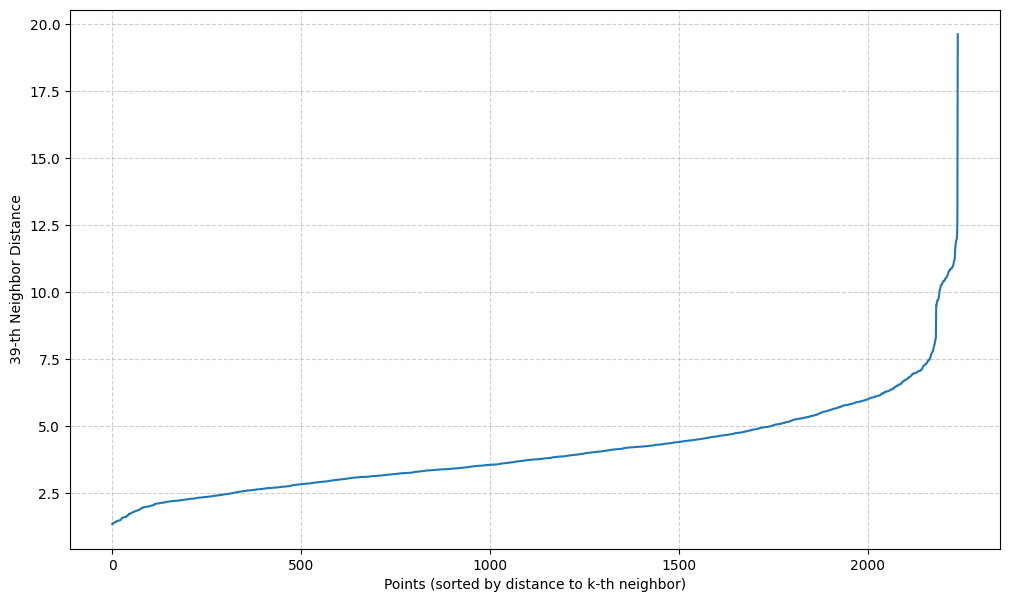

In [ ]:
#Plot the K-distance graph to find the "elbow"
plt.figure(figsize=(12, 7))
plt.plot(k_distances)
plt.xlabel("Points (sorted by distance to k-th neighbor)")
plt.ylabel(f"{k}-th Neighbor Distance")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## DBSCAN

In [ ]:
def euclidean_distance(p1, p2):
  return np.linalg.norm(p1 - p2)

In [ ]:
# To find all points within epsilon distance of a given point
def find_neighbors(X, point_idx, eps):
    neighbors = []
    for i in range(len(X)):
        if euclidean_distance(X[point_idx], X[i]) < eps:
            neighbors.append(i)
    return neighbors

In [ ]:
def dbscan(X, eps, min_pts):
  n_points = X.shape[0]

  noise = -1
  unclassified = 0 # every point at start is 0 as it is unclassified

  labels = np.full(n_points, unclassified)
  # array same size as dataset; will store cluster labels for points; initialised as zeroes

  cluster_id = 1

  for point_idx in range(n_points):
      # Skipping a point if it is already part of a cluster
      if labels[point_idx] != unclassified:
          continue

      # Finding neighbors of the current point
      neighbors = find_neighbors(X, point_idx, eps)

      # If it's not a core point, mark as noise (for now) and continue
      if len(neighbors) < min_pts:
          labels[point_idx] = noise
          continue

      # Now we know that it's a core point, so we start expanding a new cluster
      curr_neighbours = neighbors # Use a list to process neighbors
      labels[point_idx] = cluster_id

      i = 0
      while i < len(curr_neighbours):
          current_point_idx = curr_neighbours[i]

          # Change noise or unclassified points to the current cluster ID
          if labels[current_point_idx] in [noise, unclassified]:
              labels[current_point_idx] = cluster_id

              # Check if this neighbor is ALSO a core point
              new_neighbors = find_neighbors(X, current_point_idx, eps)
              if len(new_neighbors) >= min_pts:
                  # Add its neighbors to curr_neighbours if they aren't already there
                  for neigh in new_neighbors:
                      if neigh not in curr_neighbours:
                          curr_neighbours.append(neigh)
          i += 1

      # Move to the next cluster ID (since expansion of one cluster is done)
      cluster_id += 1

  return labels

## Finding Optimal Parameters using Grid Search

In [ ]:
eps_range = np.arange(5.0, 9.0, 0.5)
min_pts_range = [20, 30, 40, 50, 60]

best_score = -1
best_params = {'eps': None, 'min_pts': None}
best_labels = None

In [ ]:
for eps in eps_range:
  for m_pts in min_pts_range:
    labels = dbscan(X, eps=eps, min_pts=m_pts)

    # Calculate the number of clusters (excluding noise which is -1)
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)

    if n_clusters >= 2:  # Since the silhouette score is only defined for 2 or more clusters
        score = silhouette_score(X, labels)
        print(f"eps={eps:.2f}, min_pts={m_pts}: Found {n_clusters} clusters with silhouette score = {score:.4f}")

        # Check if this score is the best one so far
        if score > best_score:
            best_score = score
            best_params['eps'] = eps
            best_params['min_pts'] = m_pts
            best_labels = labels
    else:
        print(f"eps={eps:.2f}, min_pts={m_pts}: Found {n_clusters} clusters. Skipping score calculation.")

eps=5.00, min_pts=20: Found 2 clusters with silhouette score = 0.2484
eps=5.00, min_pts=30: Found 2 clusters with silhouette score = 0.2463
eps=5.00, min_pts=40: Found 2 clusters with silhouette score = 0.2455
eps=5.00, min_pts=50: Found 1 clusters. Skipping score calculation.
eps=5.00, min_pts=60: Found 1 clusters. Skipping score calculation.
eps=5.50, min_pts=20: Found 2 clusters with silhouette score = 0.2477
eps=5.50, min_pts=30: Found 2 clusters with silhouette score = 0.2499
eps=5.50, min_pts=40: Found 2 clusters with silhouette score = 0.2507
eps=5.50, min_pts=50: Found 2 clusters with silhouette score = 0.2494
eps=5.50, min_pts=60: Found 1 clusters. Skipping score calculation.
eps=6.00, min_pts=20: Found 2 clusters with silhouette score = 0.2473
eps=6.00, min_pts=30: Found 2 clusters with silhouette score = 0.2474
eps=6.00, min_pts=40: Found 2 clusters with silhouette score = 0.2476
eps=6.00, min_pts=50: Found 2 clusters with silhouette score = 0.2498
eps=6.00, min_pts=60: Foun

## Results and Visualization

In [ ]:
if best_params['eps'] is not None and best_params['min_pts'] is not None:
    optimal_epsilon = best_params['eps']
    print(f"Optimal Epsilon (eps): {optimal_epsilon:.2f}")

    optimal_min_pts = best_params['min_pts']
    print(f"Optimal MinPts: {optimal_min_pts}")

    optimal_labels = best_labels

    optimal_score = best_score
    print(f"Best Silhouette Score: {optimal_score:.4f}")
else:
    print("Could not find a parameter combination that resulted in 2 or more clusters.")

Optimal Epsilon (eps): 8.50
Optimal MinPts: 20
Best Silhouette Score: 0.4216


In [ ]:
# Final results
if best_params['eps'] is not None and best_params['min_pts'] is not None:
  n_clusters = len(set(optimal_labels)) - (1 if -1 in optimal_labels else 0)
  n_noise = np.sum(optimal_labels == -1) # Noise is -1
  print(f"Number of clusters with optimal parameters: {n_clusters}")
  print(f"Number of noise points with optimal parameters: {n_noise}")

Number of clusters with optimal parameters: 3
Number of noise points with optimal parameters: 7


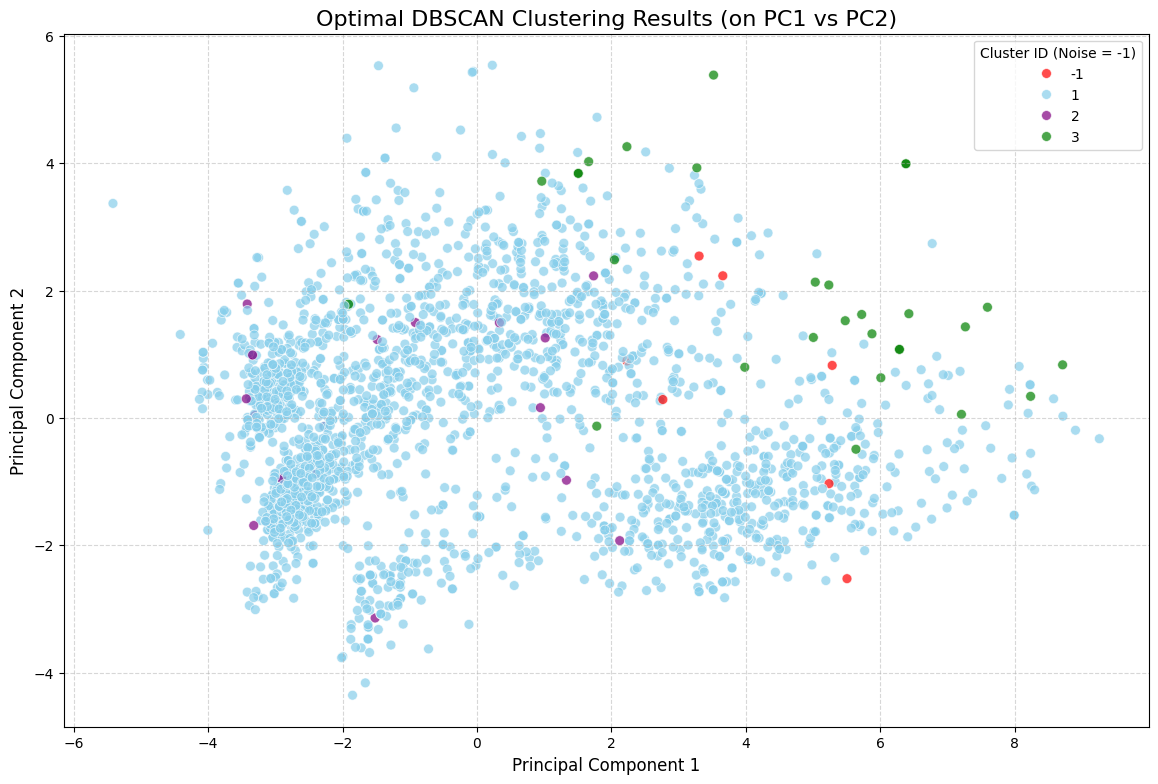

In [ ]:
# Visualize the clusters on the first two principal components (since they capture max variance)
plt.figure(figsize=(14, 9))

# Get unique labels and sort them
unique_viz_labels = sorted(list(set(optimal_labels)))

# Assign specific colors by creating a list of colors in the correct order based on unique_viz_labels
palette_list = []
for label in unique_viz_labels:
    if label == -1:
        palette_list.append('red') # Noise
    elif label == 1:
        palette_list.append('skyblue')
    elif label == 2:
        palette_list.append('purple')
    elif label == 3:
        palette_list.append('green')

sns.scatterplot(
    x=df['PC1'],
    y=df['PC2'],
    hue=optimal_labels,
    palette=palette_list, #using the created list of colors
    hue_order=unique_viz_labels, #for correct order in legend
    s=50,
    alpha=0.7,
    legend='full') # for ensuring all labels are shown in the legend

plt.title(f'Optimal DBSCAN Clustering Results (on PC1 vs PC2)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster ID (Noise = -1)')

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Cluster Insights

In [ ]:
df_og = pd.read_csv("cleaned_customer_data.csv")

In [ ]:
df_og.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Response,Total_Spending,Total_Campaigns_Accepted,Total_Children,Has_Children,Enrollment_Month,Enrollment_Year,Education_Postgraduate,Education_Undergraduate,Marital_Status_Single
0,1957,58138.0,0,0,58,635,88,546,172,88,...,1,1617,0,0,0,4,2012,False,False,True
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,27,0,2,1,8,2014,False,False,True
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,776,0,0,0,7,2013,False,False,False
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,53,0,1,1,10,2014,False,False,False
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,422,0,1,1,7,2013,True,False,False


In [ ]:
# Merging clustering info with original dataset to get cluster insights
df_og['Cluster'] = optimal_labels

In [ ]:
df_og.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Total_Campaigns_Accepted,Total_Children,Has_Children,Enrollment_Month,Enrollment_Year,Education_Postgraduate,Education_Undergraduate,Marital_Status_Single,DBSCAN_Cluster,Cluster
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,4,2012,False,False,True,1,1
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,2,1,8,2014,False,False,True,1,1
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,7,2013,False,False,False,1,1
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,1,1,10,2014,False,False,False,1,1
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,1,1,7,2013,True,False,False,1,1


In [ ]:
# Select relevant features
relevant_features = [col for col in df_og.columns if df_og[col].nunique() > 2 and not any(x in col.lower() for x in ['accepted', 'response', 'campaign', 'education', 'marital'])]

cluster_summary = df_og.groupby('Cluster')[relevant_features].mean().T # Transpose the table

In [ ]:
cluster_summary

Cluster,-1,1,2,3
Year_Birth,1975.428571,1968.841503,1963.60,1968.133333
Income,191613.714286,51613.968392,43341.55,71054.833333
Kidhome,0.285714,0.447549,0.70,0.066667
Teenhome,0.142857,0.508016,0.55,0.433333
Recency,37.428571,49.118186,52.90,48.666667
MntWines,89.714286,297.853871,150.65,898.666667
MntFruits,8.857143,26.424645,24.05,22.966667
MntMeatProducts,1037.857143,163.729730,88.60,250.300000
MntFishProducts,9.714286,37.711406,25.15,38.733333
MntSweetProducts,53.857143,27.056803,13.05,30.600000


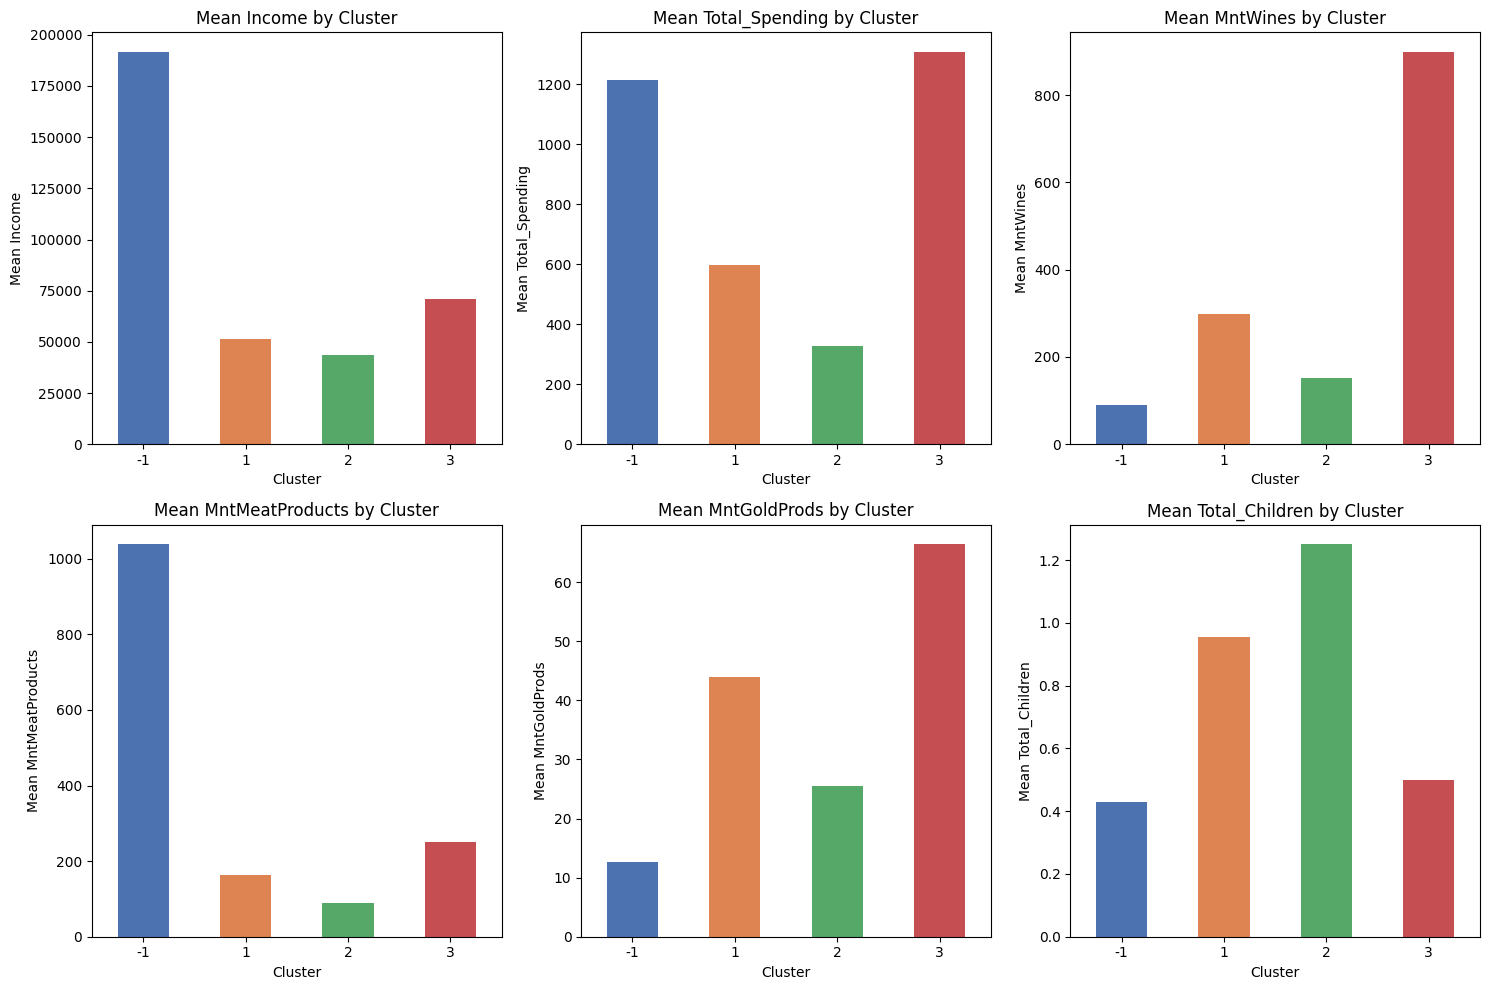

In [ ]:
# Visualizing clusters using means of features with significant difference
key_features_viz = ['Income', 'Total_Spending', 'MntWines', 'MntMeatProducts', 'MntGoldProds', 'Total_Children']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features_viz):
    plt.subplot(2, 3, i + 1)
    cluster_summary.loc[feature].plot(kind='bar', color=sns.color_palette('deep'))
    plt.title(f'Mean {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Checking median for amount related features with signifcant difference
median_features = ['Income', 'Total_Spending', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
median_features_df = df_og.groupby('Cluster')[median_features].median()

In [ ]:
median_features_df

,Income,Total_Spending,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Cluster,,,,,,,,
-1,157146.0,1608.0,9.0,2.0,1582.0,2.0,2.0,3.0
1,51381.5,382.0,173.0,8.0,66.0,12.0,8.0,24.0
2,38998.0,86.5,29.0,5.5,28.5,6.5,4.0,13.5
3,70896.5,1375.0,1044.5,15.0,136.5,27.5,15.5,46.0


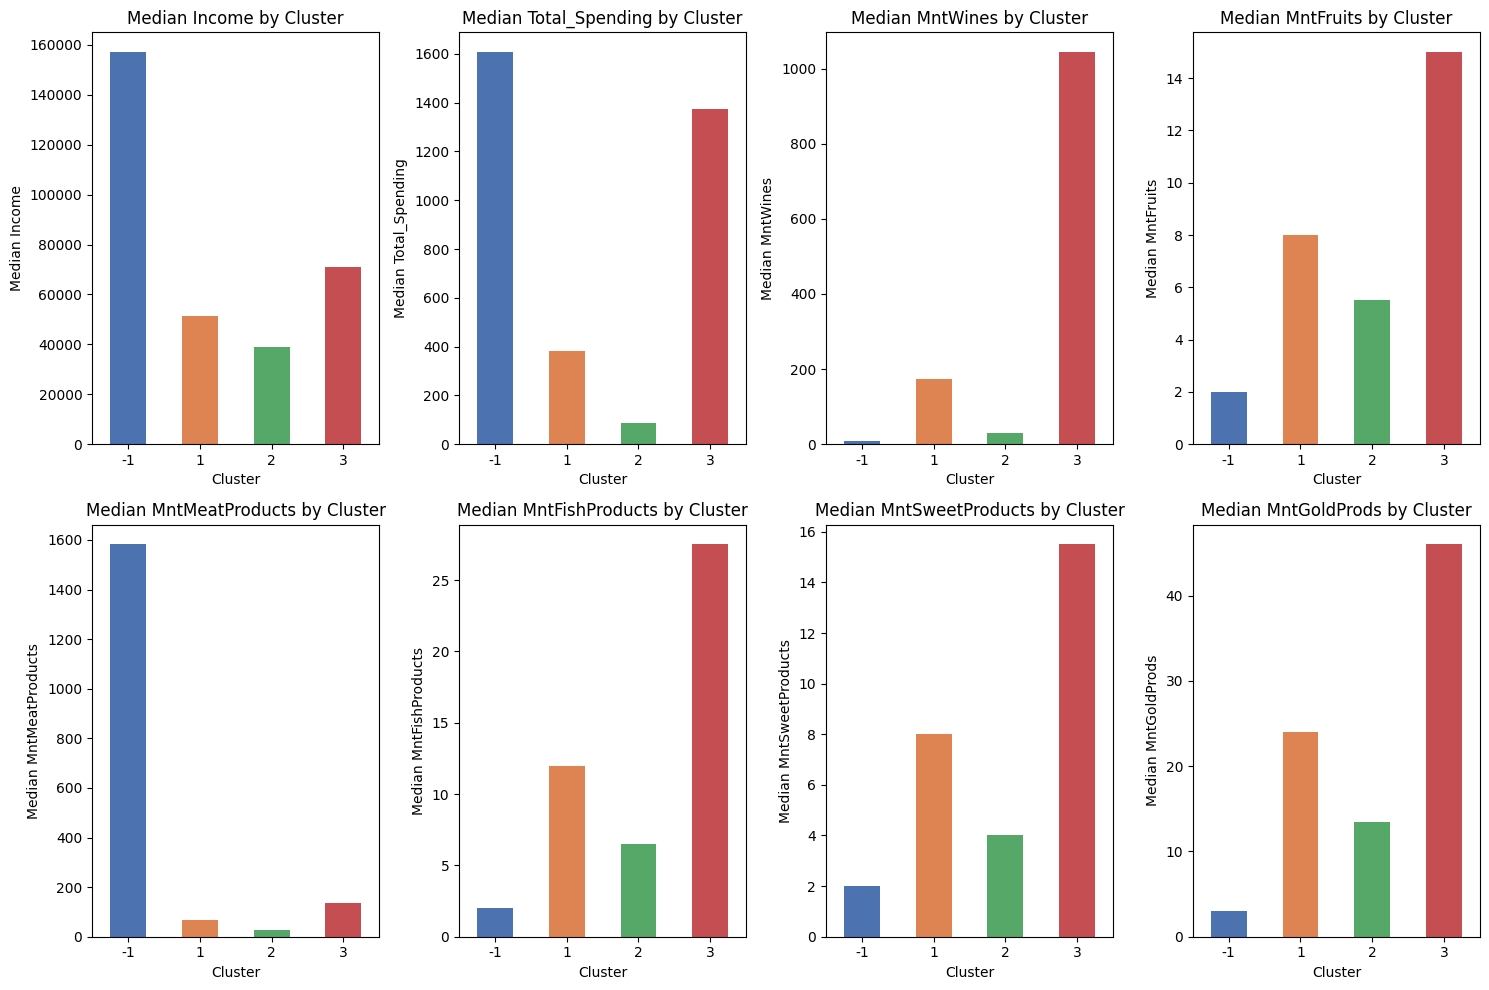

In [ ]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(median_features):
    plt.subplot(2, 4, i + 1)
    median_features_df[feature].plot(kind='bar', color=sns.color_palette('deep'))
    plt.title(f'Median {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Median {feature}')
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**INSIGHTS ON CUSTOMERS PER CLUSTER -**


*   **Cluster -1 (Noise/Outliers):** This cluster, while small and representing noise or outliers, shows some distinct characteristics, particularly in terms of very high Income and exceptionally high mean and median spending on Meat Products.


*   **Cluster 1 (Balance in income and spending):** This is the largest well-defined cluster. They show moderate mean and median income and total spending. Their spending is relatively balanced across different product categories, with moderate engagement in campaigns and a moderate number of children. They appear to be a general customer segment.


*   **Cluster 2 (Lower Spenders, Higher Children):** This cluster shows least mean and median income and total spending. They have comparitively higher number of children, and their spending on most product categories, particularly wine and meat products, is lower, while for fruits and gold is higher. Hence, this cluster seems to represent families with children who are more budget-conscious.


*   **Cluster 3 (Very High Spenders):** This cluster shows similar or slightly higher income than Cluster 1. They have the highest expenditure across all categories, and hence in total as well. They tend to have a lower number of children. Therefore, this segment appears to represent higher-spending customers, likely with fewer or no children, and have higher purchase frequency.


## Clustering output as txt file

In [ ]:
txtfile = "output.txt"
with open(txtfile, "a") as f:
  f.write('DBSCAN_result = ')
  # Convert the numpy array to a list and join elements as strings with comma
  labels_str = ",".join([str(label) for label in optimal_labels.tolist()])
  f.write(labels_str + "\n")